# jaxKAN Results

Some preliminaries

In [1]:
import jax
import jax.numpy as jnp

import optax
import flax
from flax import linen as nn

import sys
import os

import time

# Add /src to path
path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../../../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

from KAN import KAN
from PIKAN import *

import numpy as np

import matplotlib.pyplot as plt

## Diffusion Equation

### Collocation Points

In [2]:
# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,0]), np.array([1,1]), N)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([0,1]), N)) # (64, 2)
BC1_data = jnp.sin(np.pi*BC1_colloc[:,1]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([1,0]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

### Loss Function

In [3]:
def pde_loss(params, collocs, state):
    # Eq. parameter
    #D = jnp.array(0.15, dtype=float)
    D = jnp.array(1.0, dtype=float)
    
    # Define the model function
    variables = {'params' : params, 'state' : state}
    
    def u(vec_x):
        y, spl = model.apply(variables, vec_x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)  # 1st order derivative of t
    u_xx = gradf(u, 1, 2) # 2nd order derivative of x
    source = jnp.exp(-collocs[:,[0]])*(-jnp.sin(jnp.pi*collocs[:,[1]]) + (jnp.pi**2)*jnp.sin(jnp.pi*collocs[:,[1]]))
    
    # Residual
    pde_res = u_t(collocs) - D*u_xx(collocs) -source
    
    return pde_res

### Training

In [4]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [2, 6, 6, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(key, jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

In [5]:
num_epochs = 50000

model, variables, train_losses = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                             lr_vals=lr_vals, adapt_state=False, loc_w=None, nesterov=False, 
                                             num_epochs=num_epochs, grid_extend={0 : 3}, grid_adapt=[], 
                                             colloc_adapt={'epochs' : []})

Epoch 0: Performing grid update
Total Time: 129.87341046333313 s
Average time per iteration: 0.0026 s


### Plot & Save Results

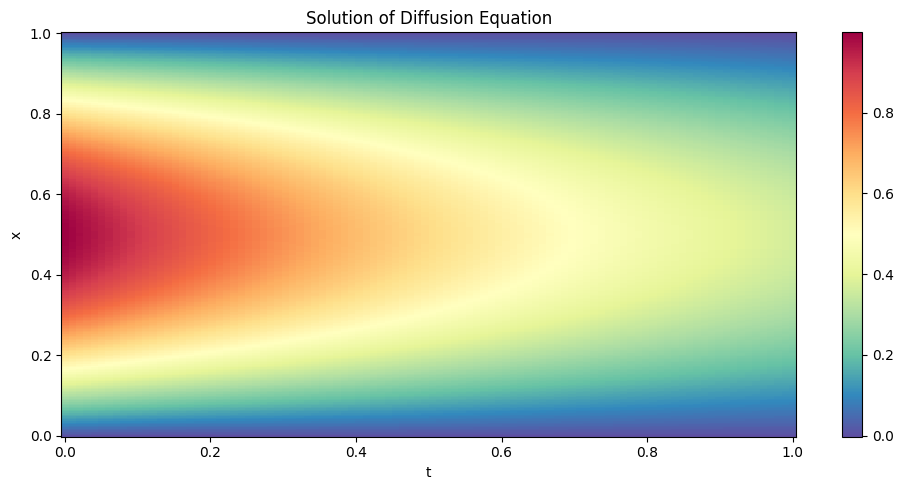

In [6]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(0.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output, _ = model.apply(variables, jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(10, 5))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Diffusion Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

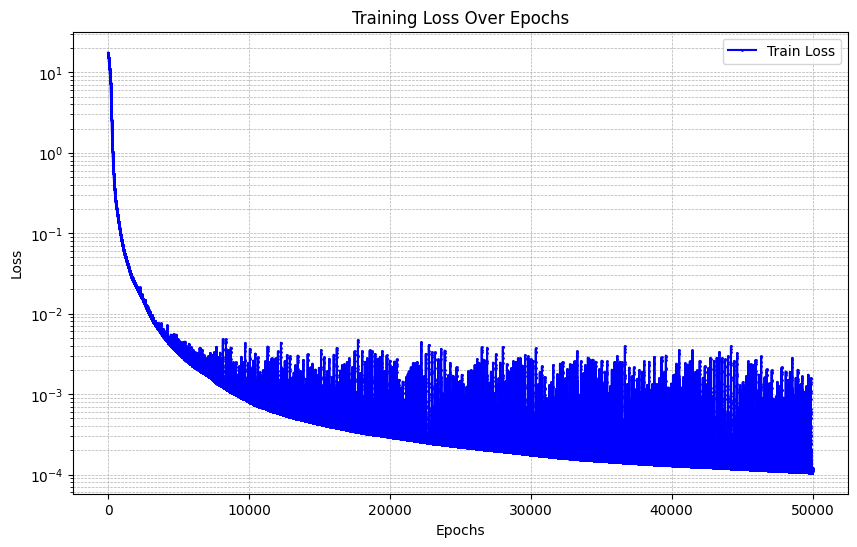

In [7]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

In [8]:
# Also calculate analytical solution
def diff_exact(t,x):
    #D = 0.15
    return np.sin(np.pi*x)*np.exp(-t)
    #return np.sin(np.pi*x)*np.exp(-D*np.pi**2*t)

ref_result = diff_exact(T, X)

# Write variables dict
serialized_variables = flax.serialization.to_bytes(variables)

with open('jaxKAN models/eq1-jaxkan.pkl', 'wb') as f:
    f.write(serialized_variables)
    
np.savez('../Plots/data/eq1-jaxkan.npz', t=t, x=x, result=resplot, ref=ref_result)

## Helmholtz Equation

### Collocation Points

In [2]:
# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,1]), N)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([-1,1]), N)) # (64, 2)
BC1_data = jnp.zeros(BC1_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,-1]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([1,-1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC4_colloc = jnp.array(sobol_sample(np.array([-1,1]), np.array([1,1]), N)) # (64, 2)
BC4_data = jnp.zeros(BC4_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc, BC4_colloc]
bc_data = [BC1_data, BC2_data, BC3_data, BC4_data]

### Loss Function

In [3]:
def pde_loss(params, collocs, state):
    # Eq. parameters
    k = jnp.array(1.0, dtype=float)
    a1 = jnp.array(1.0, dtype=float)
    a2 = jnp.array(4.0, dtype=float)
    
    # Define the model function
    variables = {'params' : params, 'state' : state}
    
    def u(vec_x):
        y, spl = model.apply(variables, vec_x)
        return y
        
    # Physics Loss Terms
    u_xx = gradf(u, 0, 2)  # 2nd order derivative of x
    u_yy = gradf(u, 1, 2) # 2nd order derivative of y

    sines = jnp.sin(a1*jnp.pi*collocs[:,[0]])*jnp.sin(a2*jnp.pi*collocs[:,[1]])
    source = -((a1*jnp.pi)**2)*sines - ((a2*jnp.pi)**2)*sines + k*sines
    
    # Residual
    pde_res = u_xx(collocs) + u_yy(collocs) + (k**2)*u(collocs) - source
    
    return pde_res

### Training

In [4]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [2, 6, 6, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(key, jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0}

# Define epochs for grid adaptation
adapt_every = 150
adapt_stop = 5000
grid_adapt = [i * adapt_every for i in range(1, (adapt_stop // adapt_every) + 1)]
grid_adapt = []

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float),
          jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

# Initialize RBA weights
loc_w = [jnp.ones((collocs.shape[0],1)), jnp.ones((BC1_colloc.shape[0],1)),
         jnp.ones((BC2_colloc.shape[0],1)), jnp.ones((BC3_colloc.shape[0],1)), jnp.ones((BC4_colloc.shape[0],1))]
loc_w = None

In [5]:
num_epochs = 50000

model, variables, train_losses = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, lr_vals=lr_vals, adapt_state=False, loc_w=loc_w, nesterov=False, num_epochs=num_epochs, grid_extend=grid_extend, grid_adapt=grid_adapt)

Epoch 0: Performing grid update
Total Time: 211.12330675125122 s
Average time per iteration: 0.0042 s


### Plot & Save Results

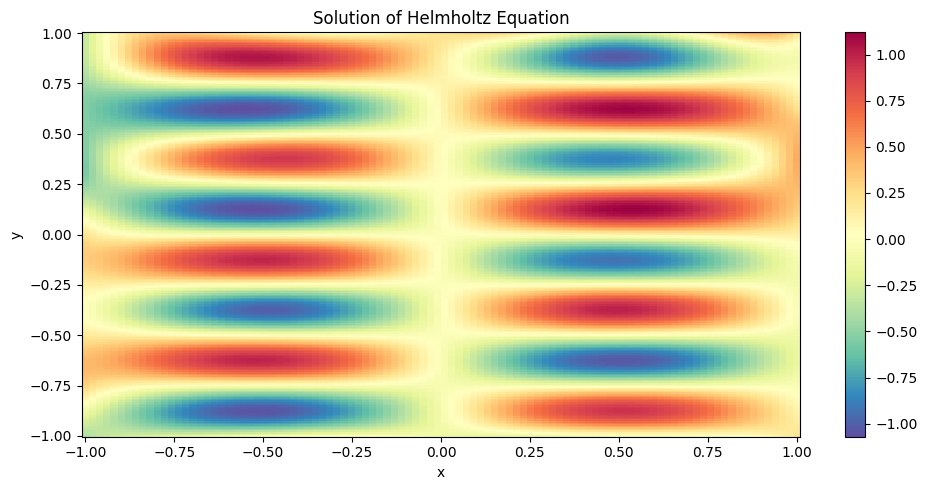

In [6]:
N_x, N_y = 100, 256

x = np.linspace(-1.0, 1.0, N_x)
y = np.linspace(-1.0, 1.0, N_y)
X, Y = np.meshgrid(x, y, indexing='ij')
coords = np.stack([X.flatten(), Y.flatten()], axis=1)

output, _ = model.apply(variables, jnp.array(coords))
resplot = np.array(output).reshape(N_x, N_y)

plt.figure(figsize=(10, 5))
plt.pcolormesh(X, Y, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Helmholtz Equation')
plt.xlabel('x')

plt.ylabel('y')

plt.tight_layout()
plt.show()

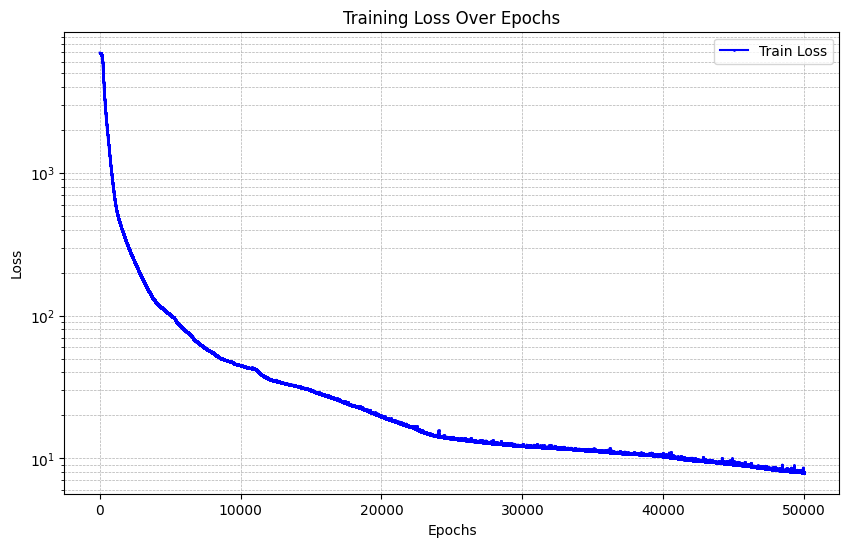

In [7]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

In [8]:
# Also calculate analytical solution
def helm_exact(x,y):
    a1 = 1.0
    a2 = 4.0
    return np.sin(a1*np.pi*x)*np.sin(a2*np.pi*y)

ref_result = helm_exact(X, Y)

# Write variables dict
serialized_variables = flax.serialization.to_bytes(variables)

with open('jaxKAN models/eq2-jaxkan.pkl', 'wb') as f:
    f.write(serialized_variables)

np.savez('../Plots/data/eq2-jaxkan.npz', x=x, y=y, result=resplot, ref=ref_result)

## Burgers' Equation

### Collocation Points

In [16]:
# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,1]), N)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([0,1]), N)) # (64, 2)
BC1_data = - jnp.sin(np.pi*BC1_colloc[:,1]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,-1]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

### Loss Function

In [17]:
def pde_loss(params, collocs, state):
    # Eq. parameter
    v = jnp.array(0.01/jnp.pi, dtype=float)
    
    # Define the model function
    variables = {'params' : params, 'state' : state}
    
    def u(vec_x):
        y, spl = model.apply(variables, vec_x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)  # 1st order derivative of t
    u_x = gradf(u, 1, 1)  # 1st order derivative of x
    u_xx = gradf(u, 1, 2) # 2nd order derivative of x
    
    # Residual
    pde_res = u_t(collocs) + u(collocs)*u_x(collocs) - v*u_xx(collocs)
    
    return pde_res

### Training

In [18]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [2, 6, 6, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(key, jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

In [19]:
num_epochs = 50000

model, variables, train_losses = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                             lr_vals=lr_vals, adapt_state=False, loc_w=None, nesterov=False, 
                                             num_epochs=num_epochs, grid_extend={0 : 3}, grid_adapt=[], 
                                             colloc_adapt={'epochs' : []})

Epoch 0: Performing grid update
Total Time: 154.73698568344116 s
Average time per iteration: 0.0031 s


### Plot & Save Results

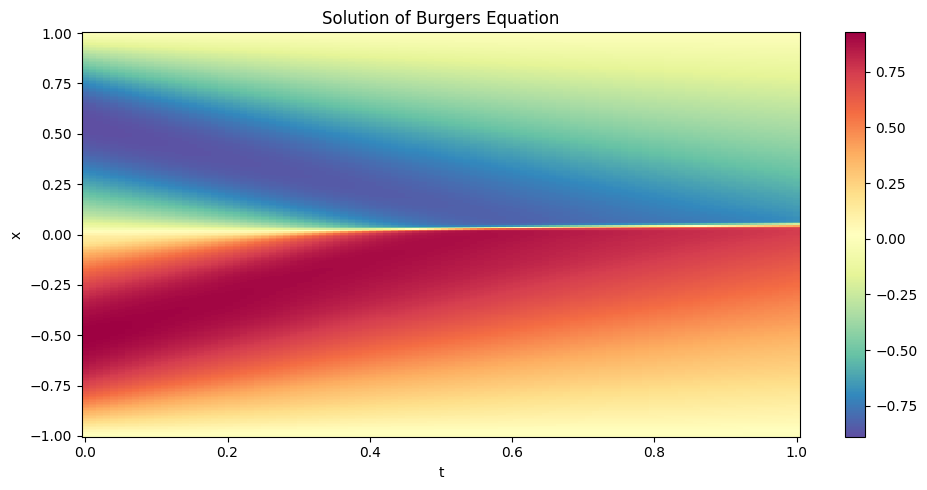

In [20]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output, _ = model.apply(variables, jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(10, 5))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Burgers Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

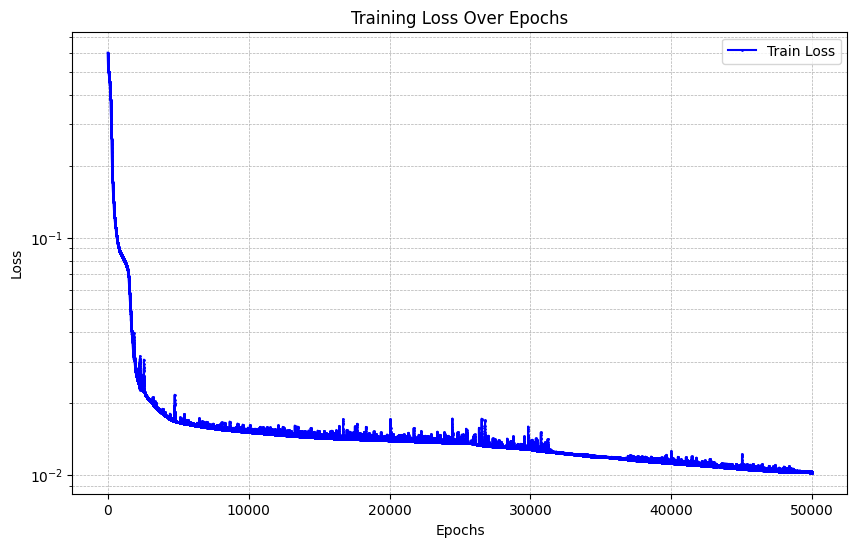

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

In [22]:
ref = np.load('../External Data/Burgers.npz')

# Write variables dict
serialized_variables = flax.serialization.to_bytes(variables)

with open('jaxKAN models/eq3-jaxkan.pkl', 'wb') as f:
    f.write(serialized_variables)

np.savez('../Plots/data/eq3-jaxkan.npz', t=t, x=x, result=resplot, ref=ref['usol'].T)

## Allen-Cahn Equation

### Collocation Points

In [23]:
# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,1]), N)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([0,1]), N)) # (64, 2)
BC1_data = ((BC1_colloc[:,1]**2)*jnp.cos(jnp.pi*BC1_colloc[:,1])).reshape(-1,1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,-1]), N)) # (64, 2)
BC2_data = -jnp.ones(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N)) # (64, 2)
BC3_data = -jnp.ones(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

### Loss Function

In [24]:
def pde_loss(params, collocs, state):
    # Eq. parameter
    D = jnp.array(0.001, dtype=float)
    c = jnp.array(5.0, dtype=float)
    
    # Define the model function
    variables = {'params' : params, 'state' : state}
    
    def u(vec_x):
        y, spl = model.apply(variables, vec_x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)  # 1st order derivative of t
    u_xx = gradf(u, 1, 2) # 2nd order derivative of x
    
    # Residual
    pde_res = u_t(collocs) - D*u_xx(collocs) - c*(u(collocs)-(u(collocs)**3))
    
    return pde_res

### Training

In [25]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [2, 6, 6, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(key, jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0}

# Define epochs for grid adaptation
adapt_every = 150
adapt_stop = 5000
grid_adapt = [i * adapt_every for i in range(1, (adapt_stop // adapt_every) + 1)]
grid_adapt = []

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

# Initialize RBA weights
loc_w = [jnp.ones((collocs.shape[0],1)), jnp.ones((BC1_colloc.shape[0],1)),
         jnp.ones((BC2_colloc.shape[0],1)), jnp.ones((BC3_colloc.shape[0],1))]
loc_w = None

In [26]:
num_epochs = 50000

model, variables, train_losses = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, lr_vals=lr_vals, adapt_state=False, loc_w=loc_w, nesterov=False, num_epochs=num_epochs, grid_extend=grid_extend, grid_adapt=grid_adapt)

Epoch 0: Performing grid update
Total Time: 144.79947900772095 s
Average time per iteration: 0.0029 s


### Plot & Save Results

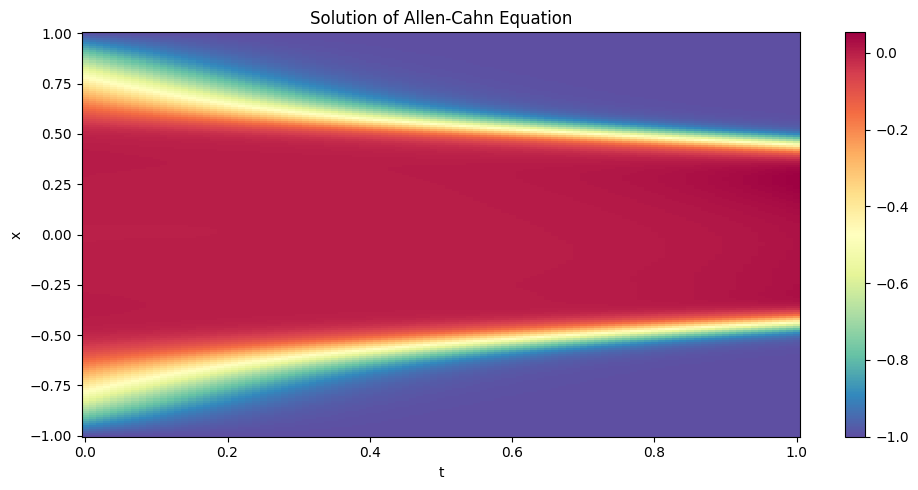

In [27]:
N_t, N_x = 101, 201

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(-1.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output, _ = model.apply(variables, jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(10, 5))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Allen-Cahn Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

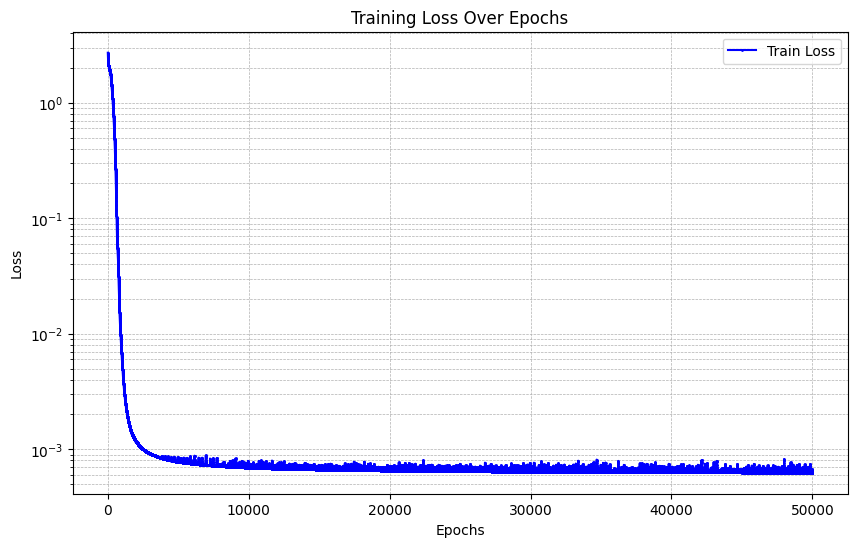

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

In [30]:
import scipy
ref = scipy.io.loadmat('../External Data/usol_D_0.001_k_5.mat')

# Write variables dict
serialized_variables = flax.serialization.to_bytes(variables)

with open('jaxKAN models/eq4-jaxkan.pkl', 'wb') as f:
    f.write(serialized_variables)

np.savez('../Plots/data/eq4-jaxkan.npz', t=t, x=x, result=resplot, ref=ref['u'])